# Recommendation System


In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [18]:
# Carregar os dados
data = pd.read_csv('improved_recommendation_data.csv')

data.head(5)

,user,interest,service,rating,frequency
0,User2,Health,Travel Fair,5,7
1,User5,Sports,Travel Fair,1,2
2,User4,Technology,Sports Event,5,9
3,User1,Education,Health Camp,1,8
4,User5,Sports,Sports Event,2,9


In [19]:
# Remover os usuários User1 a User5
data = data[~data['user'].isin(['User1', 'User2', 'User3', 'User4', 'User5'])]

# Criar a matriz usuário-serviço com interesse ponderado
data['weighted_interest'] = data['rating'] * data['frequency']
user_service_matrix = data.pivot_table(index='user', columns='service', values='weighted_interest', aggfunc='mean', fill_value=0)

# Normalizar a matriz por linha (usuário)
user_service_matrix_normalized = user_service_matrix.div(user_service_matrix.sum(axis=1), axis=0)

# Calcular a similaridade entre usuários
user_similarity = cosine_similarity(user_service_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_service_matrix.index, columns=user_service_matrix.index)

user_similarity_normalized = cosine_similarity(user_service_matrix_normalized)
user_similarity_normalized_df = pd.DataFrame(user_similarity_normalized, index=user_service_matrix_normalized.index, columns=user_service_matrix_normalized.index)

In [21]:
# Função de recomendação 
def recommend_services(user, matrix, similarity_df, top_n=5):
    if user not in matrix.index:
        print(f"Usuário '{user}' não encontrado na base.")
        return pd.Series(dtype='float64')

    similarity_scores = similarity_df[user]
    similar_users = similarity_scores.nlargest(top_n + 1).index[1:]

    weighted_scores = sum(similarity_df[user][sim_user] * matrix.loc[sim_user] for sim_user in similar_users)
    
    user_services = matrix.loc[user]
    not_rated = user_services[user_services.isnull() | (user_services == 0)].index
    
    if len(not_rated) == 0:
        print(f"{user} já utilizou todos os serviços. Recomendando os mais populares como fallback.")
        popular_services = matrix.sum().sort_values(ascending=False).head(top_n)
        return popular_services
    
    recommendations = weighted_scores.loc[not_rated].nlargest(top_n)

    if recommendations.empty:
        print(f"Nenhuma recomendação personalizada para {user}. Recomendando os mais populares.")
        popular_services = matrix.sum().sort_values(ascending=False).head(top_n)
        return popular_services
    
    return recommendations

# Função para calcular Precision@K e Recall@K
def precision_recall_at_k(user, matrix, similarity_df, top_n=5, threshold=0.2):
    recommendations = recommend_services(user, matrix, similarity_df, top_n)
    if user not in matrix.index:
        return 0.0, 0.0
    relevant_services = matrix.loc[user][matrix.loc[user] >= threshold]
    
    if len(recommendations) == 0 or len(relevant_services) == 0:
        return 0.0, 0.0 
    
    recommended_services = recommendations.index
    interseção = set(recommended_services).intersection(set(relevant_services.index)) 
    
    precision = len(interseção) / len(recommended_services)
    recall = len(interseção) / len(relevant_services)
    
    return precision, recall

# Testar com múltiplos usuários
users = user_service_matrix.index[:3] # Pega os primeiros 3 usuários reais
results = {}

for user in users:
    recommendations = recommend_services(user, user_service_matrix, user_similarity_df, top_n=5)
    recommendations_normalized = recommend_services(user, user_service_matrix_normalized, user_similarity_normalized_df, top_n=5) 
    
    precision, recall = precision_recall_at_k(user, user_service_matrix, user_similarity_df, top_n=5)
    precision_normalized, recall_normalized = precision_recall_at_k(user, user_service_matrix_normalized, user_similarity_normalized_df, top_n=5) 
    
    results[user] = {
        'recommendations': recommendations,
        'recommendations_normalized': recommendations_normalized,
        'precision': precision,
        'recall': recall,
        'precision_normalized': precision_normalized,
        'recall_normalized': recall_normalized
    }

# Exibir resultados
for user, result in results.items():
    print(f"\n📌 Recomendações para {user} (Sem Normalização):")
    print(result['recommendations'])
    print(f"Precision@K: {result['precision']:.2f}, Recall@K: {result['recall']:.2f}") 
    
    print(f"\n📌 Recomendações para {user} (Com Normalização):")
    print(result['recommendations_normalized'])
    print(f"Precision@K: {result['precision_normalized']:.2f}, Recall@K: {result['recall_normalized']:.2f}")



📌 Recomendações para SyntheticUser1 (Sem Normalização):
service
Green Market    0.947372
dtype: float64
Precision@K: 0.00, Recall@K: 0.00

📌 Recomendações para SyntheticUser1 (Com Normalização):
service
Green Market    0.026316
dtype: float64
Precision@K: 0.00, Recall@K: 0.00

📌 Recomendações para SyntheticUser10 (Sem Normalização):
service
Green Market    46.831769
AI Bootcamp     26.333293
dtype: float64
Precision@K: 0.00, Recall@K: 0.00

📌 Recomendações para SyntheticUser10 (Com Normalização):
service
Green Market    0.624695
AI Bootcamp     0.581858
dtype: float64
Precision@K: 0.00, Recall@K: 0.00

📌 Recomendações para SyntheticUser11 (Sem Normalização):
service
Eco Fair        18.489062
Digital Expo    11.554839
dtype: float64
Precision@K: 0.00, Recall@K: 0.00

📌 Recomendações para SyntheticUser11 (Com Normalização):
service
Eco Fair        0.583927
Digital Expo    0.434006
dtype: float64
Precision@K: 0.00, Recall@K: 0.00


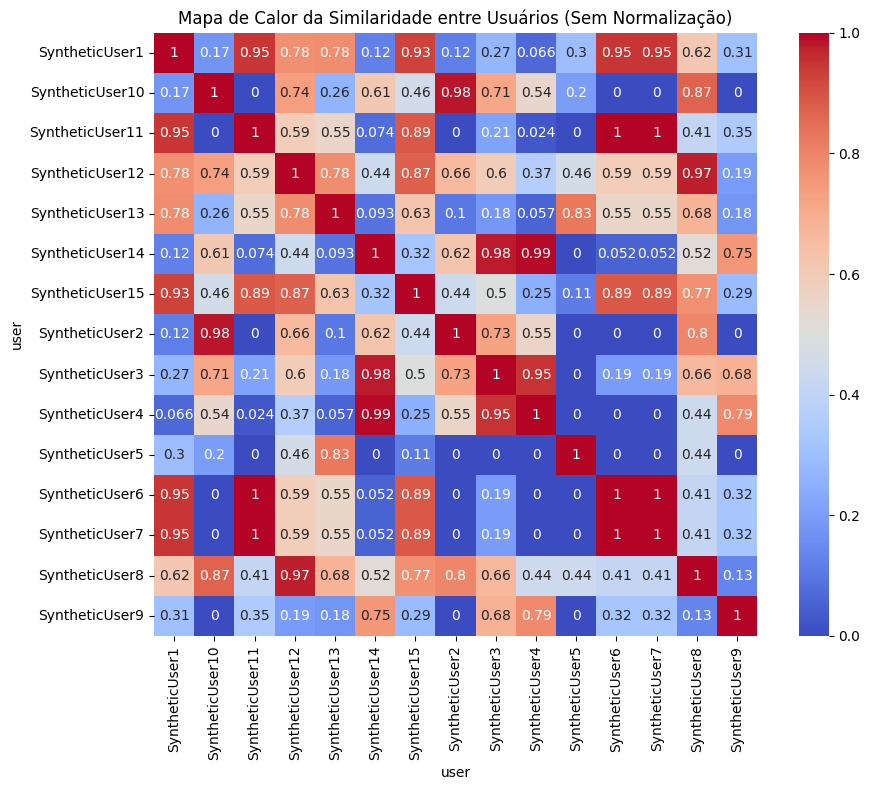

In [22]:
# Gráfico 1: Mapa de Calor (sem normalização)
plt.figure(figsize=(10, 8))
sns.heatmap(user_similarity_df, annot=True, cmap="coolwarm", square=True)
plt.title("Mapa de Calor da Similaridade entre Usuários (Sem Normalização)")
plt.tight_layout()
plt.show()

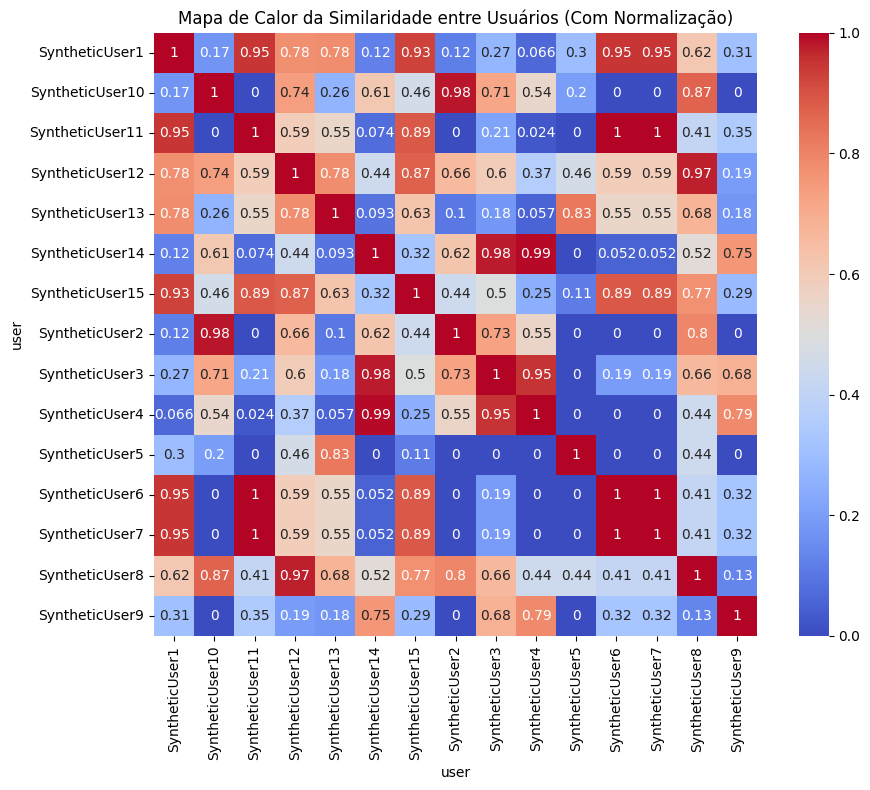

In [23]:
# Gráfico 2: Mapa de Calor (com normalização)
plt.figure(figsize=(10, 8))
sns.heatmap(user_similarity_normalized_df, annot=True, cmap="coolwarm", square=True)
plt.title("Mapa de Calor da Similaridade entre Usuários (Com Normalização)")
plt.tight_layout()
plt.show()

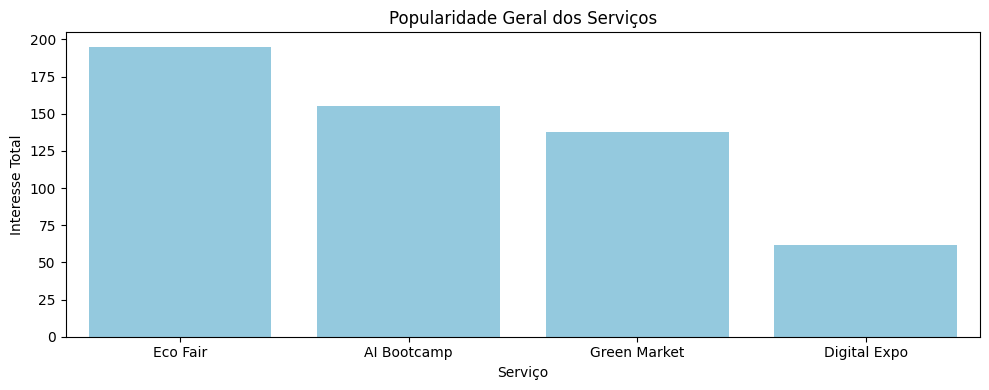

In [24]:
# Gráfico 3: Popularidade Geral dos Serviços
service_counts = user_service_matrix.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(x=service_counts.index, y=service_counts.values, color='skyblue')
plt.title("Popularidade Geral dos Serviços")
plt.xlabel("Serviço")
plt.ylabel("Interesse Total")
plt.tight_layout()
plt.show()

In [25]:
# Salvar o modelo híbrido como joblib
import joblib
joblib.dump(user_similarity_df, 'best_model.joblib')
print("Modelo salvo como 'best_model.joblib'.")

Modelo salvo como 'best_model.joblib'.


## Técnicas Utilizadas

### 1. Importações de Bibliotecas

* **`pandas`**: Para manipulação e análise de dados tabulares (DataFrames), essencial para carregar, filtrar e pivotar os dados.
* **`numpy`**: Fornece suporte para operações numéricas de alto desempenho, utilizado indiretamente em operações de `pandas` e `sklearn`.
* **`sklearn.metrics.pairwise.cosine_similarity`**: Calcula a similaridade do cosseno entre vetores, a métrica central para encontrar usuários semelhantes.
* **`matplotlib.pyplot` e `seaborn`**: Para visualização de dados, especificamente para criar mapas de calor da similaridade e gráficos de barras de popularidade.
* **`pickle` e `joblib`**: Módulos para serializar e desserializar objetos Python, usados para salvar o modelo treinado (neste caso, a matriz de similaridade entre usuários).

### 2. Carregamento e Pré-processamento de Dados

* **`data = pd.read_csv('improved_recommendation_data.csv')`**: Carrega o conjunto de dados de um arquivo CSV. Assume-se que o CSV contém informações sobre usuários, serviços, avaliações (`rating`) e frequência de uso (`frequency`).
* **`data = data[~data['user'].isin(['User1', ..., 'User5'])]`**: **Filtragem de Dados**. Remove usuários específicos (User1 a User5) do conjunto de dados. Isso pode ser feito para remover ruído, bots, ou usuários de teste.

### 3. Engenharia de Features: Interesse Ponderado

* **`data['weighted_interest'] = data['rating'] * data['frequency']`**: Cria uma nova feature, `weighted_interest` (interesse ponderado), multiplicando a `rating` (avaliação) pela `frequency` (frequência). Esta é uma forma simples de **engenharia de features** que tenta capturar um nível mais robusto de engajamento do usuário com um serviço do que apenas a avaliação bruta.

### 4. Criação da Matriz Usuário-Serviço

* **`user_service_matrix = data.pivot_table(index='user', columns='service', values='weighted_interest', aggfunc='mean', fill_value=0)`**: Transforma os dados em uma **matriz de interesse usuário-serviço**.
    * `index='user'`: Usuários se tornam os índices das linhas.
    * `columns='service'`: Serviços se tornam as colunas.
    * `values='weighted_interest'`: Os valores dentro da matriz são os interesses ponderados.
    * `aggfunc='mean'`: Se um usuário tiver múltiplos registros para o mesmo serviço, a média do interesse ponderado será usada.
    * `fill_value=0`: Preenche os valores ausentes (onde um usuário não interagiu com um serviço) com 0.

### 5. Normalização da Matriz

* **`user_service_matrix_normalized = user_service_matrix.div(user_service_matrix.sum(axis=1), axis=0)`**: **Normalização por Linha**. Normaliza cada linha (usuário) da matriz `user_service_matrix`. Isso significa que o interesse total de cada usuário será 1. A normalização ajuda a lidar com o "problema de escala" (alguns usuários avaliam/interagem mais do que outros), tornando as comparações de similaridade mais justas.

### 6. Cálculo de Similaridade entre Usuários (Similaridade do Cosseno)

* **`user_similarity = cosine_similarity(user_service_matrix)`**: Calcula a **similaridade do cosseno** entre todos os pares de usuários na matriz de interesse não normalizada.
* **`user_similarity_df = pd.DataFrame(...)`**: Converte a matriz de similaridade NumPy em um DataFrame Pandas com rótulos de usuário.
* **`user_similarity_normalized = cosine_similarity(user_service_matrix_normalized)`**: Repete o cálculo da similaridade do cosseno para a matriz de interesse *normalizada*.
* **`user_similarity_normalized_df = pd.DataFrame(...)`**: Converte a matriz de similaridade normalizada em um DataFrame.

    * **Similaridade do Cosseno**: Mede o ângulo entre dois vetores. Se os vetores são na mesma direção (usuários com gostos muito semelhantes), o cosseno é 1. Se são opostos, é -1. Se são ortogonais (sem relação), é 0. É uma métrica comum para dados esparsos como os gerados por filtragem colaborativa.

### 7. Função de Recomendação (`recommend_services`)

Esta função implementa a lógica central da filtragem colaborativa:

* **Identificação de Usuários Semelhantes**: `similarity_df[user].nlargest(top_n + 1).index[1:]` encontra os `top_n` usuários mais semelhantes ao usuário alvo (excluindo o próprio usuário).
* **Cálculo de Scores Ponderados**: `sum(similarity_df[user][sim_user] * matrix.loc[sim_user] for sim_user in similar_users)`: Para cada serviço, ele soma os interesses dos usuários semelhantes, ponderando pelo quão semelhantes eles são ao usuário alvo. Isso é o cerne da filtragem colaborativa.
* **Filtragem de Serviços Já Utilizados**: `user_services[user_services.isnull() | (user_services == 0)].index` identifica os serviços que o usuário alvo ainda não utilizou (ou cujo interesse ponderado é 0). Isso evita recomendar algo que o usuário já conhece.
* **Geração de Recomendações**: `weighted_scores.loc[not_rated].nlargest(top_n)` seleciona os `top_n` serviços com os maiores scores ponderados dentre aqueles que o usuário ainda não utilizou.
* **Fallback para Serviços Populares**:
    * Se o usuário já utilizou todos os serviços, ou
    * Se nenhuma recomendação personalizada puder ser gerada (ex: nenhum serviço não avaliado tem score positivo),
    * O sistema recomenda os `top_n` serviços mais populares (`matrix.sum().sort_values(ascending=False).head(top_n)`). Isso é uma estratégia de **tratamento de cold start para itens** ou **fallback para usuários com poucas interações**.
* **Tratamento de Usuário Desconhecido**: Verifica se o usuário está na matriz e retorna um erro se não estiver, uma forma básica de **tratamento de cold start para usuários**.

### 8. Métricas de Avaliação (`precision_recall_at_k`)

Esta função calcula a **Precision@K** e **Recall@K**, métricas comuns para avaliar sistemas de recomendação:

* **`recommendations = recommend_services(...)`**: Obtém as recomendações para o usuário.
* **`relevant_services = matrix.loc[user][matrix.loc[user] >= threshold]`**: Define o que é um serviço "relevante" para o usuário. Neste caso, um serviço é relevante se o interesse ponderado do usuário por ele for maior ou igual a um `threshold` (limiar). Isso simula o "verdadeiro interesse" do usuário.
* **`interseção = set(recommended_services).intersection(set(relevant_services.index))`**: Calcula quantos dos serviços recomendados são realmente relevantes.
* **Precision@K**: `len(interseção) / len(recommended_services)`. A proporção de recomendações que são relevantes. Um Precision@K alto significa que o sistema é bom em não recomendar coisas irrelevantes.
* **Recall@K**: `len(interseção) / len(relevant_services)`. A proporção de serviços relevantes que foram encontrados pelo sistema. Um Recall@K alto significa que o sistema é bom em encontrar a maioria das coisas que o usuário acharia relevantes.
* **Tratamento de Casos Vazios**: Retorna 0.0, 0.0 se não houver recomendações ou serviços relevantes.

### 9. Teste e Exibição de Resultados

* **`for user in users:`**: O sistema é testado para os primeiros 3 usuários.
* Calcula e exibe as recomendações, Precision@K e Recall@K para ambas as abordagens (com e sem normalização), permitindo comparar o impacto da normalização.

### 10. Visualização de Dados

* **`sns.heatmap(...)`**: Gera mapas de calor para visualizar a matriz de similaridade entre usuários (com e sem normalização). Isso ajuda a entender visualmente como os usuários se agrupam por gostos semelhantes.
* **`sns.barplot(...)`**: Gera um gráfico de barras da popularidade geral dos serviços, mostrando quais serviços são mais utilizados/avaliados no conjunto de dados.

### 11. Persistência do Modelo

* **`joblib.dump(user_similarity_df, 'best_model.joblib')`**: Salva a matriz de similaridade entre usuários (aqui, a não normalizada é escolhida como "best_model"). Em um sistema de recomendação User-Based CF, esta matriz é o "modelo" que permite gerar recomendações sem recalcular tudo do zero.

## Possíveis Próximos Passos (Melhorias Futuras)

### 1. Refinamento do Modelo de Filtragem Colaborativa

* **Item-Based Collaborative Filtering:** Em vez de encontrar usuários semelhantes, encontre serviços semelhantes. Isso pode ser mais escalável para um grande número de usuários, e pode ser menos suscetível ao problema do "usuário frio" (cold start para usuários) se houver dados suficientes de itens.
* **Híbridos de User-Based e Item-Based:** Combinar as abordagens pode mitigar as fraquezas de cada uma.
* **Algoritmos de Matriz Fatorada (Matrix Factorization):**
    * **SVD (Singular Value Decomposition) / SVD++:** Decompor a matriz usuário-serviço em componentes latentes (features ocultas). Isso é muito eficaz para capturar padrões complexos e pode lidar com a esparsidade dos dados.
    * **ALS (Alternating Least Squares):** Uma alternativa ao SVD, especialmente útil para matrizes esparsas e para lidar com grandes volumes de dados.
* **Modelos Baseados em Deep Learning:**
    * **Autoencoders:** Redes neurais que podem aprender representações densas da matriz usuário-serviço.
    * **Neural Collaborative Filtering (NCF):** Modelos que substituem a multiplicação de vetores latentes (como no SVD) por uma rede neural para capturar interações mais complexas.
    * **Wide & Deep Learning:** Combinar um modelo linear (Wide) que memoriza features interativas com um modelo de deep learning (Deep) que generaliza.

### 2. Tratamento de Cold Start

* **Para Novos Usuários (Cold Start User):**
    * **Recomendações Baseadas em Popularidade:** Já implementado como fallback, mas pode ser a estratégia inicial.
    * **Recomendações Baseadas em Conteúdo:** Se houver metadados sobre os usuários (demografia, interesses expressos em cadastro), recomendar com base neles.
    * **Perguntas de Engajamento:** Pedir ao novo usuário para avaliar alguns serviços populares para coletar informações iniciais.
* **Para Novos Serviços (Cold Start Item):**
    * **Recomendações Baseadas em Conteúdo:** Se houver metadados sobre os serviços (categorias, descrição, tags), recomendar com base na similaridade desses atributos.
    * **"Impulsionar" Novos Itens:** Exibir novos serviços para usuários selecionados ou em posições de destaque para coletar interações iniciais.

### 3. Melhorias na Engenharia de Features

* **Inclusão de Metadados:** Incorporar informações adicionais sobre usuários (demografia, histórico de navegação, cliques) e serviços (categoria, preço, descrição) pode enriquecer o modelo, transformando-o em um **sistema de recomendação híbrido**.
* **Contexto Temporal:** O interesse de um usuário por um serviço pode mudar ao longo do tempo. Incorporar a data/hora da interação pode melhorar a relevância das recomendações (ex: recomendar serviços mais recentes).
* **Tratamento de Interações Implícitas:** Além de `rating` e `frequency`, considerar cliques, visualizações, tempo gasto em um serviço como indicadores de interesse.
* **Peso Decrescente por Interações Antigas:** Interações mais recentes podem ser mais relevantes do que interações antigas. Aplicar um decaimento no `weighted_interest` com base na idade da interação.

### 4. Avaliação e Validação Mais Robustas

* **Conjunto de Validação Separado:** Além do conjunto de teste, usar um conjunto de validação para ajuste de hiperparâmetros e *early stopping* (se aplicável).
* **Validação Cruzada (Cross-Validation):** Para uma avaliação mais confiável do desempenho do modelo, especialmente se o dataset não for muito grande.
* **Métricas Adicionais:**
    * **MAP (Mean Average Precision):** Considera a ordem das recomendações.
    * **NDCG (Normalized Discounted Cumulative Gain):** Pondera a relevância de um item pela sua posição na lista de recomendações.
    * **Cobertura/Novidade/Diversidade:** Medir quão diversos são os itens recomendados, e se o sistema consegue recomendar itens novos ou de cauda longa, não apenas os mais populares.
* **Testes A/B (Online Evaluation):** A forma mais definitiva de avaliar um sistema de recomendação. Lançar diferentes versões do algoritmo para diferentes grupos de usuários e medir o impacto direto em métricas de negócio (cliques, conversões, engajamento).

### 5. Otimização e Escalabilidade

* **Otimização de Hiperparâmetros:** Utilizar técnicas como Grid Search, Random Search ou Otimização Bayesiana para encontrar os melhores parâmetros para a similaridade do cosseno, `top_n`, ou para os algoritmos de fatoração de matriz.
* **Incremental Updates:** Para sistemas em tempo real com dados que mudam constantemente, o modelo precisará ser atualizado incrementalmente em vez de retreinado do zero.
* **Otimização de Desempenho:** Para grandes datasets, considerar bibliotecas otimizadas para operações de matriz (ex: SciPy esparso para matrizes de user-item) e computação distribuída (ex: Apache Spark, Dask).